<a id='1MLF1'></a>
## 1. Contents of MLFlow Logistic Regression Model with scikit-learn to predict Credit Card frauds or anomalies

* [2 About Dataset](#2MLF1)
* [3 Loading the dataset](#3MLF1)
* [4 Data Processing](#4MLF1)</br>
    [4.1 Creating "normal" and "anomaly" dataframes](#41MLF1lrskl)</br>
    [4.2 Splitting train, test and validate sets](#42MLF1lrskl)</br>
    [4.3 Rescaling or Standardizing the train, test and validate sets](#43MLF1lrskl)</br>
* [5 Model training](#5MLF1lrskl)</br>
    * [5.1 Logging and Viewing MLFlow runs](#51MLF1lrskl)</br>
* [6 Loading a Logged Model](#6MLF1lrskl)</br>
* [7 Model Validation (Parameter Tuning) with MLFlow](#7MLF1lrskl)</br>
    [7.1 Parameter Tunning - Broad Seaerch](#71MLF1lrskl)</br>
    [7.2 Parameter Tunning - Guided Seaerch](#72MLF1lrskl)</br>
* [8. Deploying the Model on Local Model Serving mode](#8MLF1lrskl)</br>
* [9. Querying the Model](#9MLF1lrskl)</br>
    [9.1 Querying Without Scaling](#91MLF1lrskl)</br>
    [9.2 Querying With Scaling](#92MLF1lrskl)</br>
    [9.3 Batch Querying](#93MLF1lrskl)</br>
* [References](#RefMLF1lrskl)</br>

In this notebook we will analyze the credit card data set in order to later build simple anomaly detection models.

data source: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

<a id='2MLF1'></a>
## 2. About the program

### Context
This program is about in how to build a simple logistic regression model in scikit-learn, including the process of
k-fold cross validation to tune a hyperparameter in scikit-learn.

[Return to Contents of credit card dataset analysis](#1MLF1)

<a id='3MLF1'></a>
## 3. Loading the dataset

In the code below, you will find that some of the imports are unnecessary, such as importing all of sklearn when you only use a bit of its functionality. This is done for the purpose of displaying the version.

In [69]:
import numpy as np #Version: 1.21.5
import pandas as pd #version 1.3.5
import matplotlib.pyplot as plt #matplotlib version 3.5.1
from pylab import rcParams
rcParams['figure.figsize'] = 14,8 
%matplotlib inline
#Python version 3.7.13

import seaborn as sns # version 0.11.2
import sklearn # version 1.0.2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.model_selection import KFold

import mlflow
import mlflow.sklearn

print("seaborn: {}".format(sns.__version__))
print("sklearn: {}".format(sklearn.__version__))
print("MLFlow: {}".format(mlflow.__version__))

seaborn: 0.11.2
sklearn: 1.0.2
MLFlow: 1.30.0


In [34]:
cc = pd.read_csv("creditcard.csv")

Dropping the column named `Time` because it adds very large data values that ultimately don’t have much of a correlation with the column Class. Model performance is boosted slightly simply by dropping the extraneous information

In [35]:
cc = cc.drop("Time", axis=1)

In the case of deep learning models, your model might eventually learn that the Time data does not correlate very well with the Class labels and may place less importance on nodes processing that data. Eventually, it might even ignore the Time data. However, you can speed up the learning process by cutting out these types of features from your training sets. This is because you’re sparing the models the time and resources needed to figure that out.

[Return to Contents of credit card dataset analysis](#1MLF1)

<a id='4MLF1'></a>
## 4 Data Processing

<a id='41MLF1lrskl'></a>
### 4.1 Creating "normal" and "anomaly" dataframes

This is where data analysis comes into play. Because you know that a massive disparity between the data counts in each class exists, you will now take care to specially craft the data sets so that it is ensured that a good amount of anomalies end up in each data set. 

If we simply select 100,000 data points from "cc", split it into training / test / validate sets and continue, it is entirely possible that very few or even no anomalies end up in one or more of those sets. Then at that point, we would have a lot of trouble in getting the model to properly learn this task.

In [36]:
print(f"Number of Anomalies records:{cc[cc.Class == 1].shape}")
print(f"Number of Normal records:{cc[cc.Class == 0].shape}")

Number of Anomalies records:(492, 30)
Number of Normal records:(284315, 30)


With that in mind, let’s create data frames for the normal points and for the fraudulent points. In the following cell's code, we filter out the respective values by class, and sample 50% of the entire data frame’s normal points to comprise the normal data in this context. 

The "normal" set will contain half (`frac=0.5`) of original records, randomly selected (`random_state=2020`). This new 'normal' set has top have its own new index, so we have to reset its index (`reset_index(drop=True`).

By seting the random_state to a specific value, the results of the random sampling should be the same no matter how many times you repeat it, helping with reproducibility. Unfortunately, given the nature of how models learn, you cannot expect to get the same results every time for something like neural networks, for example.

In [37]:
normal = cc[cc.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = cc[cc.Class == 1]

In [38]:
print(f"Number of Anomalies records:{anomaly[anomaly.Class == 1].shape}")
print(f"Number of Normal records:{normal[normal.Class == 0].shape}")

Number of Anomalies records:(492, 30)
Number of Normal records:(142158, 30)


As we can see, there is still a big disparity between the normal points and the anomalies. <span style='background :lightgreen'>In the case of **logistic regression**, the model is still able to learn how to distinguish between the two, but in the case of **neural networks**, for example, this disparity means the model never really learns how to classify anomalies.</span> However, as we will see later we can tell the model to weigh the anomalies far more in its learning process compared to the normal points.

[Return to Contents of credit card dataset analysis](#1MLF1)

<a id='42MLF1lrskl'></a>
### 4.2 Splitting train, test and validate sets

Normally the scikitlearn `train_test_split` it is code like: 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 2020)

bein y sets for the labels

Now you can start creating the **train/test/validate** split (3 datasets). However, scikitlearn provides functionality to create **train/test** splits only (2 datasets). To get around that (that restriction), you will create **train and test** sets, and then split the **train set** again into **train and validate** sets.

First, you will split the data into train and test data, keeping the normal points and anomalies separate. To do this, you will use the `train_test_split()` function from scikit-learn. Commonly passed parameters are
> x: The x set you want to split up

> y: The y set you want to split up corresponding to the x set

> test_size: The proportion of data in x and y that you want to randomly sample for the test set.

In [39]:
normal_train, normal_test = train_test_split(normal, test_size = 0.2,
                                             random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly,test_size = 0.2,
                                               random_state = 2020)

In [40]:
print(f"Number of 'normal_train' records:{normal_train.shape}")
print(f"Number of 'normal_test' records:{normal_test.shape}")

Number of 'normal_train' records:(113726, 30)
Number of 'normal_test' records:(28432, 30)


In [41]:
print(f"Number of 'anomaly_train' records:{anomaly_train.shape}")
print(f"Number of 'anomaly_test' records:{anomaly_test.shape}")

Number of 'anomaly_train' records:(393, 30)
Number of 'anomaly_test' records:(99, 30)


Now, we can create our **training and validation sets** by calling the
same function on the respective training sets. 

You don’t want to split it by 20% again, though, since the training set is already 80% of the original data set. If you used a 20% split again, the validation set would be 16% of the original data, and the training set would be 64% of the original data.

You will instead be doing a 60-20-20 split for the training, testing, and validation data, respectively, and so you will be using a new test_size
value of 0.25 to ensure these proportions hold (0.25 * 0.8 = 0.2).

In [42]:
normal_train, normal_validate = train_test_split(normal_train, 
                                                 test_size = 0.25,
                                                 random_state = 2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train,
                                                   test_size = 0.25,
                                                   random_state = 2020)

In [43]:
print(f"Number of 'normal_train' records:{normal_train.shape}")
print(f"Number of 'normal_test' records:{normal_test.shape}")
print(f"Number of 'normal_validate' records:{normal_validate.shape}")
print(f"Number of 'anomaly_train' records:{anomaly_train.shape}")
print(f"Number of 'anomaly_test' records:{anomaly_test.shape}")
print(f"Number of 'anomaly_validate' records:{anomaly_validate.shape}")

Number of 'normal_train' records:(85294, 30)
Number of 'normal_test' records:(28432, 30)
Number of 'normal_validate' records:(28432, 30)
Number of 'anomaly_train' records:(294, 30)
Number of 'anomaly_test' records:(99, 30)
Number of 'anomaly_validate' records:(99, 30)


To create the final training, testing, and validation sets, we have to concatenate the respective normal and anomaly data splits.

First, lets define x_train, x_test, and x_validate:

In [44]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate, anomaly_validate))

In [45]:
print(f"Number of 'x_train' records:{x_train.shape}")
print(f"Number of 'x_test' records:{x_test.shape}")
print(f"Number of 'x_validate' records:{x_validate.shape}")

Number of 'x_train' records:(85588, 30)
Number of 'x_test' records:(28531, 30)
Number of 'x_validate' records:(28531, 30)


Next, **define y_train, y_test, and y_validate**(target values):

In [46]:
y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

In [47]:
print(f"Number of 'y_train' records:{y_train.shape}")
print(f"Number of 'y_test' records:{y_test.shape}")
print(f"Number of 'y_validate' records:{y_validate.shape}")

Number of 'y_train' records:(85588,)
Number of 'y_test' records:(28531,)
Number of 'y_validate' records:(28531,)


In [48]:
y_train[0:3]

array([0, 0, 0], dtype=int64)

In [49]:
y_train[-3:]

array([1, 1, 1], dtype=int64)

Seems that last rows contain the anomalies labels

**Finally**, we have to drop the column `Class` in the x sets since it would  defeat the purpose of teaching the model how to learn what makes up a normal and a fraudulent transaction if you gave it the label directly.

In [50]:
x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)

In [51]:
print(f"Number of 'x_train' records:{x_train.shape}")
print(f"Number of 'y_train' records:{y_train.shape}")
print(f"Number of 'x_test' records:{x_test.shape}")
print(f"Number of 'y_test' records:{y_test.shape}")
print(f"Number of 'x_validate' records:{x_validate.shape}")
print(f"Number of 'y_validate' records:{y_validate.shape}")

Number of 'x_train' records:(85588, 29)
Number of 'y_train' records:(85588,)
Number of 'x_test' records:(28531, 29)
Number of 'y_test' records:(28531,)
Number of 'x_validate' records:(28531, 29)
Number of 'y_validate' records:(28531,)


[Return to Contents of credit card dataset analysis](#1MLF1)

<a id='43MLF1lrskl'></a>
### 4.3 Feature scaling for train, test and validate sets

In [52]:
scaler = StandardScaler() #creates an instance of StandardScaler
# trains the scaler by fitting on the entire dataframe
# so that it standardizes all of your data in the same way. 
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))

# applies the scaler to each "x" set to ensure the best results
# since you don’t want to standardize x_train, x_test, and x_validate 
# in their own ways since it would create discrepancies in 
# the data and would be problematic for the model. 
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

In [53]:
type(x_train)

numpy.ndarray

In [54]:
print(x_train.shape)

(85588, 29)


[Return to Contents of credit card dataset analysis](#1MLF1)

<a id='5MLF1lrskl'></a>
### 5 Model training with MLFlow

Let’s define the train and test functions to organize the code. This is also where you start integrating MLFlow into your code. Here is the train function:

In [55]:
def train(sk_model, x_train, y_train):
    '''
    Trains a scikit model and logs a mlflow accuracy
    '''
    sk_model = sk_model.fit(x_train, y_train)
    train_acc = sk_model.score(x_train, y_train)
    # defining a training accuracy metric that will be
    # logged by MLFlow
    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Accuracy: {train_acc:.3%}")

Within the `train` function we create a new metric specifically for the training accuracy so we can keep track of this metric. Furthermore, we are telling MLFlow to log this metric, so that MLFlow will keep track of this value in each run.

When you log multiple runs, you can compare this metric across each of those runs so that you can pick a model with the best AUC score for example.

Now lets create an evaluate function

In [56]:
def evaluate(sk_model, x_test, y_test):
    '''
    Evaluates a scikit model. Reporting the
    AUC score and accuracy and Plots for the 
    confusion matrix and the ROC curve are generated,
    and both the metrics and the graphs are logged to MLFlow
    '''
    eval_acc = sk_model.score(x_test, y_test)
    preds = sk_model.predict(x_test)
    auc_score = roc_auc_score(y_test, preds)
    # tells MLFlow to log two more metrics: the AUC
    # score and the accuracy on the test set
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)
    print(f"AUC Score: {auc_score:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")
    roc_plot = plot_roc_curve(sk_model, x_test, y_test,
                              name='Scikit-learn ROC Curve')
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()
    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")
    # tells MLFlow to save the plots generated by
    # matplotlib and by seaborn. 
    mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

With the `evaluate` function we can look at each of the graphs for each training run and do so in a highly organized manner. You must first
save these plots, which you do in the same directory. Then, you must tell
MLFlow to grab the artifacts to log them like so make sure that they have the same names as the graphs you saved.

[Return to Contents of credit card dataset analysis](#1MLF1)

<a id='51MLF1lrskl'></a>
### 5.1 Logging and Viewing MLFlow runs

Let’s run the code that actually sets the experiment name, starts the MLFlow run, and executes all this code:

In [57]:
# instanties a `LogisticRegression` model (`sk_model`)
sk_model = LogisticRegression(random_state=None,
                              max_iter=400, solver='newton-cg')

In [58]:
#Set the given experiment as the active experiment.
# The experiment must either be specified by name via `experiment_name` or by ID via `experiment_id`.
mlflow.set_experiment("scikit_learn_experiment")

<Experiment: artifact_location='file:///C:/Users/conza/SridharBeginMLFlow/mlruns/1', creation_time=1667427801561, experiment_id='1', last_update_time=1667427801561, lifecycle_stage='active', name='scikit_learn_experiment', tags={}>

What this does is that it puts the `run` under whatever experiment name
you pass in as a parameter. If that name does not exist, MLFlow will create
a new one under that name and put the run there

The following cell has many embeeded explanations for each line.

For the line `mlflow.sklearn.log_model(sk_model, "log_reg_model")`, as you will see later, most other frameworks follow the same style when saving the model. 

There are a couple exceptions, but we will cover this when the time comes. In this case, you are calling mlflow.sklearn, but if you wanted to log a PySpark model, you would do mlflow.spark. 

Basically, the framework the model was built in must match the framework module of MLFlow when logging the model. It is possible to create a custom “model” in MLFlow and log this as well, something that is covered in the documentation. 

You can use this custom model to then specify how you want the prediction function to work. If you’d like to process the data some more before making predictions, for example, MLFlow allows you to specify this extra functionality through the use of the MLFlow PyFunc module. 

Train Accuracy: 99.893%
AUC Score: 85.341%
Eval Accuracy: 99.874%


C:\Users\conza\Anaconda3\envs\TFKERAS\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


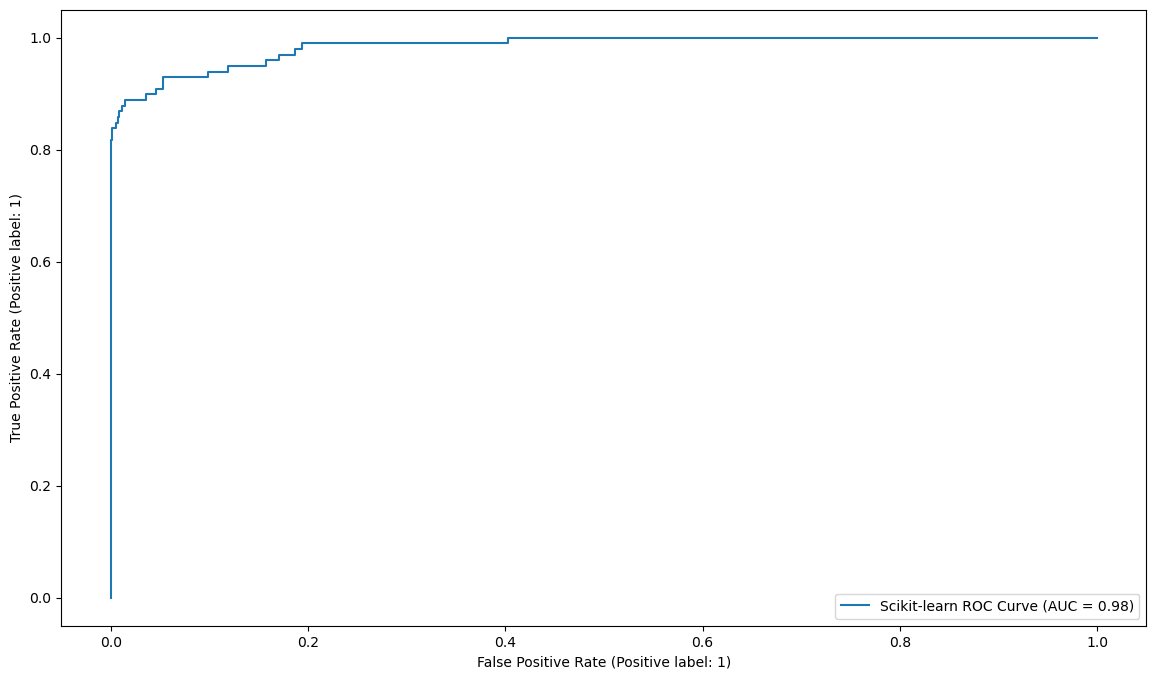

Model run:  cd38920dad234123895c8d4ff278a96d


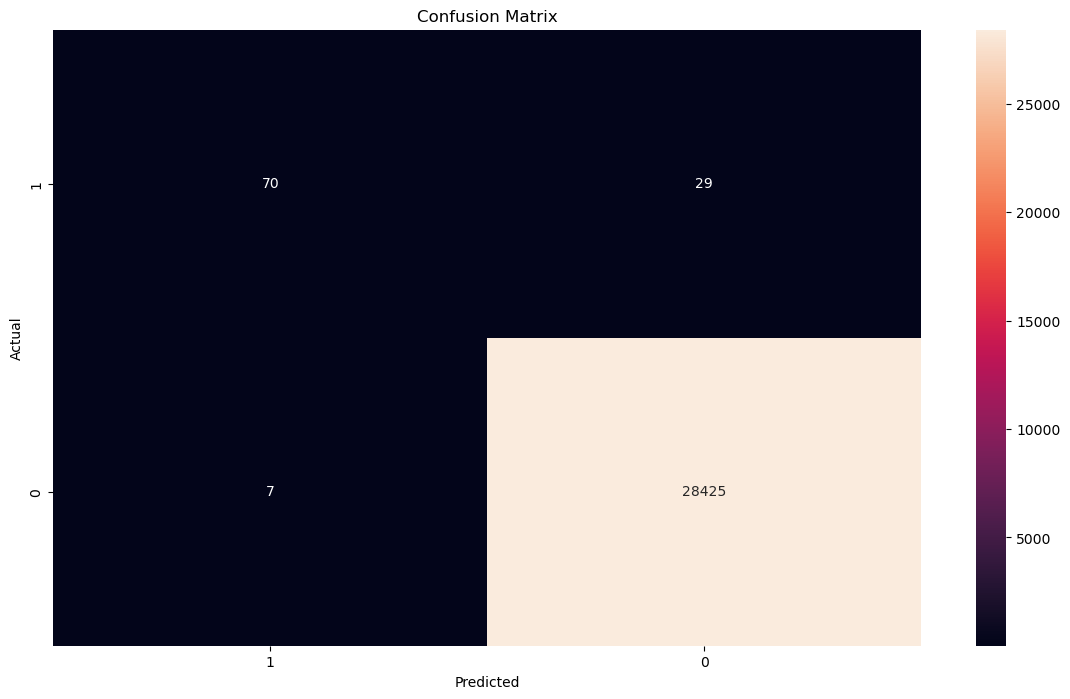

In [59]:
# The 'with` line of code allows to chunk all of the code under 
# the context of one MLFlow run. 
# This ensures that there are no discrepancies between where
# your metrics are being logged, and that it doesn’t create two
# different runs when you mean it to log everything for the same run.
with mlflow.start_run():
    # calls for `train` function passing a previously created instance
    # of a scikit logistic Regression model. train will record the
    # score or accuracy of the model
    train(sk_model, x_train, y_train)
    # evaluate the model loging the auc and eval_acc scores and also
    # logging its plots
    evaluate(sk_model, x_test, y_test)
    # This line of code is the general convention to use when you’re 
    # logging a model. The parameters, in order, are the model you’re
    # saving and then the name you’re setting for the model when saving.
    # In this case, you are saving your logistic regression model with 
    # the name `log_reg_model` in this run.
    mlflow.sklearn.log_model(sk_model, "log_reg_model")
    # This line of code essentially gets the current run that the model
    # and metrics are being logged to and prints it out.
    # This makes it handy if you want to retrieve the run directly from
    # the notebook itself instead of going to the UI to do so.
    print("Model run: ", mlflow.active_run().info.run_uuid)
    # this tells MLFlow to end the current run. In cases where there
    # is an error in the `mlflow.start_run` code block, and the run does
    # not terminate, do this to forcibly end the current run.
    # Basically, it is there to ensure that MLFlow stops the run after
    # you executed all the code relevant to the current run.
    mlflow.end_run()

You can see that MLFlow automatically generates a new experiment if it does not already exist, so you can create a new experiment directly
from the code. You can also see that the rest of the code basically outputs as usual, except it also prints the run ID (`Model run:`) of the current MLFlow run just as you specified. You will use this later when you select the specific model that you want to serve.

What you will do next is open up the UI MLFlow provides where you can actually look at all the experiments and model runs.

Finally, you also log the model itself as an artifact with MLFlow.MLFlow will modularize this code so that it will work with the code provided by MLFlow to support implementations of a variety of MLOps principles

First, open command prompt/powershell/terminal. Then, you must go into the directory that contains this notebook file. List the contents of the directory (or view this in file explorer/within Jupyter itself) and you will notice a new directory named *mlruns*.

What you want to do now is to make sure your command prompt, powershell, or terminal is in the same directory that contains the foldes mlruns:  
`cd .\SridharBeginMLFlow`)

If you installed all of your packages in Conda, make sure you’ve activated the Conda environment before running the `mlflow ui -p 1234`

For this use case, it is assumed to be into the current conda environment already activated. Otherwise it can be done by the command: 

**conda activate c:\Users\conza\Anaconda3\envs\TFKERAS**

Then just simply write the command: **mlflow ui -p 1234**

The command mlflow ui hosts the MLFlow UI locally on the default port of 5000. However, the options -p 1234 tell it that you want to host it specifically on the port 1234.

Now, open a browser and type in http://localhost:1234 or
http://127.0.0.1:1234. Both should take you to the same MLFlow UI. 

In the mlflow window, to the left are the experiments. Notice that there is an experiment titled "Default" and one titled "scitkit_learn_experiment", which is the one just created.By selecting its checkbox and after clicking on one of the Models (sklearn) another window will pop up showing much more information. 

You can even log graphs, along with the models themselves.<span style='background :cyan'> With MLFlow, you can stay highly organized with your experiments **even if you don’t necessarily need the deployment capabilities to the cloud services**.</span>

[Return to Contents of credit card dataset analysis](#1MLF1)

<a id='6MLF1lrskl'></a>
## 6. Loading a Logged Model

Let’s briefly look at how you can load the models logged by MLFlow.
To better understand what this path is, let’s split it up into three sections: 
>the format (runs:/), 

>the run ID (YOUR_RUNID_HERE), and 

> the model name that you used when you logged it (log_reg_model)

In [60]:
# loads the second ran model
loaded_model = mlflow.sklearn.load_model("runs:/fdc61ce3971944c0b1fdef3e54535544/log_reg_model")

This is now the same model that you had when MLFlow logged it in the first place. With this, you can call something like .score() and see that it’s the same as during training:

In [61]:
loaded_model.score(x_test, y_test)

0.9987382145736217

This outputs the accuracy as the model is evaluated on the test set. If this truly is the same model, then the accuracy should match what was output earlier during the evaluation portion of the model run.

Now you know how to load a model from a specific MLFlow run.

With that, you’ve seen some of the functionality that MLFlow provides and how it can help in keeping your prototyping experiments much more organized.

As you will see shortly, this entire pipeline that you just
explored is pretty much all you need to recreate the train, test, validate pipeline that you saw earlier.

Before you move on to looking at how you can use MLFlow with other frameworks, let’s go over how you can use MLFlow functionality to vastly improve the model validation process.

[Return to Contents of credit card dataset analysis](#1MLF1)

<a id='7MLF1lrskl'></a>
## 7. Model Validation (Parameter Tuning) with MLFlow

<a id='71MLF1lrskl'></a>
### 7.1 Parameter Tunning - Broad Seaerch

Simmilar as in program `LR_SKL_CreCarAnmDet1.ipynb` the model validation will be implemented assigning anomaly weights on the features or variables and using a 'KFold' cross-validation (from sklearn.model_selection import KFold)

In [62]:
# list of weights to iterate over:
anomaly_weights = [1, 5, 10, 15]
# define the number of folds
num_folds = 5
# instatnties a kfold cross validator or generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

Now lets code the validation script, which is simmilar to the one in the program `LR_SKL_CreCarAnmDet1.ipynb`but with some MLFlow code additions to log everything during the validation process

In [67]:
'''
# list of weights to iterate over:
anomaly_weights = [1, 5, 10, 15]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)
'''
# The 'set_experiment' sets the given experiment as the
# active experiment. The experiment must either be specified
# by name via `experiment_name` or by ID via `experiment_id`.
mlflow.set_experiment("sklearn_creditcard_broad_search")

logs = []
'''
logs list keeps records of the results of the `sk_model` 
given its parametes  `x_validate[test]` and `y_validate[test]`,
as well the results of the predictions `preds` given its
parameters of `sk_model.predict(x_validate[test])` 
for each run of anomaly weights `anomaly_weights` 
and for each of the five folds per `anomaly_weights`. 
'''
# empty dictionary for results
d={'FoldNum':[],"AnomWe":[],"AUC":[],"EvalAcc":[]} 
Folds = []
AnomWeights = []
AUCPerFoldAW = []
AccuPerFoldAW = []

# The first loop goes over each of the anomaly weights.
for f in range(len(anomaly_weights)):
    # We set the fold=1 to initiate the fold number per 
    # each 'anomaly_weights' round.
    fold = 1 
    auc_scores= []
    accuracies = []
  
    for train, test in kfold.split(x_validate, y_validate):
        # starts to run the experiment and logging metrics
        # and artifacts
        with mlflow.start_run():
            weight = anomaly_weights[f]
            # logs current anomaly_weight value
            mlflow.log_param("anomaly_weight", weight)
            # set the class_weights dictionary and pass it into the 
            # model as a hyperparameter.
            class_weights= { 0:1, 1: weight }
            sk_model = LogisticRegression(random_state=None,
                                          max_iter=400,
                                          solver='newton-cg',
                                          class_weight=class_weights).fit(x_validate[train],y_validate[train])
            
            for h in range(40):
                train_acc = sk_model.score(x_validate[train], y_validate[train])
                mlflow.log_metric("train_acc", train_acc)
                eval_acc = sk_model.score(x_validate[test],y_validate[test])
                preds = sk_model.predict(x_validate[test])
                mlflow.log_metric("eval_acc", eval_acc)
                try:
                    auc_score = roc_auc_score(y_validate[test], preds)
                except:
                    auc_score = -1
        
            mlflow.log_metric("auc_score", auc_score)
            
            
            Folds.append(fold)
            AnomWeights.append(weight)
            AUCPerFoldAW.append(eval_acc)
            AccuPerFoldAW.append(auc_score)

            print('---------------', end="")
            print(f"\nfold {fold}\nAnomaly Weight: {weight}")
            print("AUC: {}\neval_acc: {}".format(auc_score, eval_acc))
            accuracies.append(eval_acc)
            auc_scores.append(auc_score)
            log = [sk_model, x_validate[test], y_validate[test], preds]
            logs.append(log)
            mlflow.sklearn.log_model(sk_model, f"anom_weight_{weight}_fold_{fold}")
                        
            fold = fold + 1
            mlflow.end_run()
            
    print('\n++++++++++++++++', end="")
    print("\nAverages for Anomaly Weight:", weight)
    print("AUC: ", np.mean(auc_scores))
    print("Accuracy: ", np.mean(accuracies))
    print('++++++++++++++++', end="")


#updates de directory       
d.update({'FoldNum':Folds,
          "AnomWe":AnomWeights,
          "AUC":AUCPerFoldAW,
          "EvalAcc":AccuPerFoldAW})

print('\n/////////////////', end="")
print("\n Total Averages: ")
print("AUC: ", np.mean(auc_scores))
print("Accuracy: ", np.mean(accuracies))
print("Best: ")
print("AUC: ", np.max(auc_scores))
print("Accuracy: ", np.max(accuracies))

---------------
fold 1
Anomaly Weight: 10
AUC: 0.9243845612801126
eval_acc: 0.9982477659015244
---------------
fold 2
Anomaly Weight: 10
AUC: 0.9753109687146626
eval_acc: 0.9980722046968104
---------------
fold 3
Anomaly Weight: 10
AUC: 0.9313783507133262
eval_acc: 0.9985979670522257
---------------
fold 4
Anomaly Weight: 10
AUC: 0.8943851628367561
eval_acc: 0.9985979670522257
---------------
fold 5
Anomaly Weight: 10
AUC: 0.8820013855427915
eval_acc: 0.9985979670522257

++++++++++++++++
Averages for Anomaly Weight: 10
AUC:  0.9214920858175297
Accuracy:  0.9984227743510024
++++++++++++++++---------------
fold 1
Anomaly Weight: 50
AUC: 0.922626164937577
eval_acc: 0.9947432977045734
---------------
fold 2
Anomaly Weight: 50
AUC: 0.9734640030154541
eval_acc: 0.9943918682089029
---------------
fold 3
Anomaly Weight: 50
AUC: 0.9296190262939033
eval_acc: 0.99509288468279
---------------
fold 4
Anomaly Weight: 50
AUC: 0.9183271172480171
eval_acc: 0.9940413599719593
---------------
fold 5
Anom

KeyboardInterrupt: 

Once running this script, it had should loged the parameter for the anomaly weight and all of the metrics that you specified for every fold generated.
When the script finishes, go to your MLFlow UI and switch the experiment to sklearn_creditcard_broad_search to see all the runs you just logged.

By a quick looking at the mlflow ui we can notice the results for every one of the five folds for every of the 4 anomaly_weights values. So we could not use any more the d dictionary we used to get a dataframe for all this results in program `LR_SKL_CreCarAnmDet1.ipynb`

In the metrics by clicking the 'auc_score' column we sorts this by the AUC score to find the best parameters for the AUC. We observe that the best AUC result was for anomaly_weight=5

If we like to filter the  AUC scores that are at least 0.90, the UI provides a search bar that performs a search based on the SQL WHERE clause. So, to filter your output, type the following and click Search:
**metrics."auc_score" >= 0.90**

Notice that we put "auc_score" in quotation marks. This is for cases where the metric name that you’ve logged contains characters like a dash where it might not recognize the name if you typed it out like so:
metrics.auc-score The proper convention for a metric logged as "auc-score" would be to filter it.

Now let’s say that of these scores, you want to see the scores for anomaly weights of 5 only. It doesn’t appear that there are any results with the anomaly weight of 1, so we will start with 5. For that, let’s type and search the following:

metrics."auc_score" >= 0.90 AND parameters.anomaly_weight = "5"

You put the 5 in quotation marks because the parameters seem to be logged as string values, whereas the metrics are logged as floats. From this output, it seems that only two of the five folds with the anomaly weight set to 5 had an AUC score above 0.90.

Let’s quickly search over the other parameters and check how many folds had an AUC score above 0.90 as well: 

metrics."auc_score" >= 0.90 AND parameters.anomaly_weight = "10"
metrics."auc_score" >= 0.90 AND parameters.anomaly_weight = "15"

Three runs for an anomaly weight of 10 and 15 also met your criteria for minimum AUC score

What if you tighten the AUC score requirement to be a minimum of 0.95? Let’s check the runs for a minimum AUC of 0.95 and with an anomaly weight of 5, 10 and 15. 

Only one run per each weight has achieved an AUC score above 0.95. 

So, from these results, you cannot really infer which weight setting is the best, so you have to narrow the scope of your hyperparameter search. As far as you know, you could have missed the best setting, and it could be somewhere in between 5 and 10 or 10 and 15.

So what if the higher anomaly weights were more consistent in their AUC scores, and the smaller anomaly weight runs achieving the highest AUC scores were just flukes (coincidences)? To see how each anomaly weight setting did, first remove the query statement, and click Search again. Next, make sure that the AUC scores are in descending order. 

The, using the following code, let’s filter over all of the values for anomaly weights and check what the AUC scores look like, seplacing 1 with 5, 10, and 15.

**parameters.anomaly_weight = "1"**

None of the scores have gone above 0.9, so you can automatically rule
out this anomaly weight setting. If you go back to your script, you can see that the average AUC for anomaly_weight=1 was around 0.8437.
> Averages for Anomaly Weight: 1

> AUC:  0.8437245395411569

> Accuracy:  0.9985980161860246

Looking at the AUC scores of the runs with anomaly weight of 5 in descending order. You can see a noticeable increase in the average AUC score when compared to an anomaly weight of 1. The scores have improved noticeably. If you go back to the original script’s output, you can see that the average AUC score is now 0.9116.
> Averages for Anomaly Weight: 5

> AUC:  0.9116151890283671

> Accuracy:  0.9985980100442996

For the rest of the anomaly weights (10 and 15):
> Averages for Anomaly Weight: 10

> **AUC:  0.9214920858175297**

> **Accuracy:  0.9984227743510024**

> Averages for Anomaly Weight: 15

> AUC:  0.9212283479853886

> Accuracy:  0.9978970181373118

Looking at the AUC scores of the runs with an anomaly weight of 10 and 15 in descending order, the scores are very similar, but the average is ever so slightly worse for anomaly weight=15, so the true range seems to be somewhere in between 10 and 15

Based on these results, you can see that there **seems to be an increase from 5 to 10, but a slight decrease from 10 to 15**. From this data, the ideal range seems to be somewhere in between 10 and 15, but again, the decrease in average AUC from 10 to 15 is essentially negligible(insignificant). And so, what if it’s potentially beyond 15, and you started out with the wrong range to search over?

From the results of this validation experiment, it seems that you haven’t found a definite range of values that you know for sure you can focus on. And so, you must expand your range even more just to see if you can get better results with higher anomaly weights.

Looking at the distribution of data and how heavily the normal points outnumber the anomalies, you can use your intuition to help guide your hyperparameter search and expand the range far more. 

Now that you know this, let’s try expanding the range far more.

[Return to Contents of credit card dataset analysis](#1MLF1)

<a id='72MLF1lrskl'></a>
### 7.2 Parameter Tuning – Guided Search

The best overall performances were achieved by anomaly weights 10 and 15, but it seems to be on an upward trend the higher up you go with the anomaly weight.

Now that you know this, let’s try another validation run with a broader range of anomaly weights to try. 

The validation script itself should be the same, so if you simply replaced the anomaly weights in the original cell, **don’t run the validation
script yet!** Let’s create a new experiment so that you don’t clutter the
original tuning experiment with these new runs.

Modify the following line in the old validation script so that it goes
from 

mlflow.set_experiment("sklearn_creditcard_broad_search")

to

mlflow.set_experiment("sklearn_creditcard_guided_search")

In [68]:
'''
# list of weights to iterate over:
anomaly_weights = [10, 50, 100, 150, 200]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)
'''
anomaly_weights = [10, 50, 100, 150, 200]
# The 'set_experiment' sets the given experiment as the
# active experiment. The experiment must either be specified
# by name via `experiment_name` or by ID via `experiment_id`.
mlflow.set_experiment("sklearn_creditcard_guided_search")

logs = []
'''
logs list keeps records of the results of the `sk_model` 
given its parametes  `x_validate[test]` and `y_validate[test]`,
as well the results of the predictions `preds` given its
parameters of `sk_model.predict(x_validate[test])` 
for each run of anomaly weights `anomaly_weights` 
and for each of the five folds per `anomaly_weights`. 
'''
# empty dictionary for results
d={'FoldNum':[],"AnomWe":[],"AUC":[],"EvalAcc":[]} 
Folds = []
AnomWeights = []
AUCPerFoldAW = []
AccuPerFoldAW = []

# The first loop goes over each of the anomaly weights.
for f in range(len(anomaly_weights)):
    # We set the fold=1 to initiate the fold number per 
    # each 'anomaly_weights' round.
    fold = 1 
    auc_scores= []
    accuracies = []
  
    for train, test in kfold.split(x_validate, y_validate):
        # starts to run the experiment and logging metrics
        # and artifacts
        with mlflow.start_run():
            weight = anomaly_weights[f]
            # logs current anomaly_weight value
            mlflow.log_param("anomaly_weight", weight)
            # set the class_weights dictionary and pass it into the 
            # model as a hyperparameter.
            class_weights= { 0:1, 1: weight }
            sk_model = LogisticRegression(random_state=None,
                                          max_iter=400,
                                          solver='newton-cg',
                                          class_weight=class_weights).fit(x_validate[train],y_validate[train])
            
            for h in range(40):
                train_acc = sk_model.score(x_validate[train], y_validate[train])
                mlflow.log_metric("train_acc", train_acc)
                eval_acc = sk_model.score(x_validate[test],y_validate[test])
                preds = sk_model.predict(x_validate[test])
                mlflow.log_metric("eval_acc", eval_acc)
                try:
                    auc_score = roc_auc_score(y_validate[test], preds)
                except:
                    auc_score = -1
        
            mlflow.log_metric("auc_score", auc_score)
            
            
            Folds.append(fold)
            AnomWeights.append(weight)
            AUCPerFoldAW.append(eval_acc)
            AccuPerFoldAW.append(auc_score)

            print('---------------', end="")
            print(f"\nfold {fold}\nAnomaly Weight: {weight}")
            print("AUC: {}\neval_acc: {}".format(auc_score, eval_acc))
            accuracies.append(eval_acc)
            auc_scores.append(auc_score)
            log = [sk_model, x_validate[test], y_validate[test], preds]
            logs.append(log)
            mlflow.sklearn.log_model(sk_model, f"anom_weight_{weight}_fold_{fold}")
                        
            fold = fold + 1
            mlflow.end_run()
            
    print('\n++++++++++++++++', end="")
    print("\nAverages for Anomaly Weight:", weight)
    print("AUC: ", np.mean(auc_scores))
    print("Accuracy: ", np.mean(accuracies))
    print('++++++++++++++++', end="")


#updates de directory       
d.update({'FoldNum':Folds,
          "AnomWe":AnomWeights,
          "AUC":AUCPerFoldAW,
          "EvalAcc":AccuPerFoldAW})

print('\n/////////////////', end="")
print("\n Total Averages: ")
print("AUC: ", np.mean(auc_scores))
print("Accuracy: ", np.mean(accuracies))
print("Best: ")
print("AUC: ", np.max(auc_scores))
print("Accuracy: ", np.max(accuracies))

2022/11/03 11:13:08 INFO mlflow.tracking.fluent: Experiment with name 'sklearn_creditcard_guided_search' does not exist. Creating a new experiment.


---------------
fold 1
Anomaly Weight: 10
AUC: 0.9243845612801126
eval_acc: 0.9982477659015244
---------------
fold 2
Anomaly Weight: 10
AUC: 0.9753109687146626
eval_acc: 0.9980722046968104
---------------
fold 3
Anomaly Weight: 10
AUC: 0.9313783507133262
eval_acc: 0.9985979670522257
---------------
fold 4
Anomaly Weight: 10
AUC: 0.8943851628367561
eval_acc: 0.9985979670522257
---------------
fold 5
Anomaly Weight: 10
AUC: 0.8820013855427915
eval_acc: 0.9985979670522257

++++++++++++++++
Averages for Anomaly Weight: 10
AUC:  0.9214920858175297
Accuracy:  0.9984227743510024
++++++++++++++++---------------
fold 1
Anomaly Weight: 50
AUC: 0.922626164937577
eval_acc: 0.9947432977045734
---------------
fold 2
Anomaly Weight: 50
AUC: 0.9734640030154541
eval_acc: 0.9943918682089029
---------------
fold 3
Anomaly Weight: 50
AUC: 0.9296190262939033
eval_acc: 0.99509288468279
---------------
fold 4
Anomaly Weight: 50
AUC: 0.9183271172480171
eval_acc: 0.9940413599719593
---------------
fold 5
Anom

Now you can run this code. Once it finishes, go back to the UI, refresh it, and select the new experiment named sklearn_creditcard_guided_search. 

The whole point of broadening the range of anomaly weights that you are performing the tuning experiment on is to help you understand where the best hyperparameter range may lie. You did not know this initially, so you picked a range that was too small to help you discover the best value. Now that you do know, you have expanded your search range considerably.

From the results of this experiment, you can hopefully narrow your range a lot more and repeat the experiment with a massively reduced range and arrive at the correct hyperparameter setting.

You will now filter out each of the values by each unique anomaly weight (10, 50, 100, 150, and 200) to get an idea of how the runs with that setting performed

Averages for Anomaly Weight: 10 <br>
AUC:  0.9214920858175297<br>
**Accuracy:  0.9984227743510024**<br>

Averages for Anomaly Weight: 50<br>
AUC:  0.9247505170837659<br>
Accuracy:  0.994462154108037<br>

Averages for Anomaly Weight: 100<br>
AUC:  0.9326652039576586<br>
Accuracy:  0.9903263043134993<br>

Averages for Anomaly Weight: 150<br>
AUC:  0.93652513497249<br>
Accuracy:  0.9863306393885642<br>

Averages for Anomaly Weight: 200<br>
**AUC:  0.9395730983624768**<br>
Accuracy:  0.9824751101994336<br>

So, from this, you know that the best hyperparameter setting is somewhere above 200. You simply shift the range of the scope to start at 200 and search over a slightly different area, and once you have found a good range of values to search over (eventually the AUC scores will start trending down as you increase the anomaly weight), you can narrow the focus and start searching again.

After a certain amount of precision with the parameter value, you start to see diminishing returns where the added effort only produces negligible improvements in performance, but you will likely encounter this as you start getting deeper into the decimal values.

[Return to Contents of credit card dataset analysis](#1MLF1)

<a id='8MLF1'></a>
## 8. Deploying the Model on Local Model Serving mode

Serving and querying models locally is very easy and can be done in the command line. You only need the experiment ID and the run ID to serve the model. This is where the print statement from earlier can apply, as it prints the run ID of that specific run. If you just want to serve the latest model, you may do so using that ID. Otherwise, you can look in the MLFlow UI, select a model run that
suits your needs, and paste the run this way.

Before you begin, go to the MLFlow UI once again, and click the experiment `scikit_learn_experiment`. Pick a run and copy the run ID. Don’t forget the **model name that you logged the model with either, which should be `log_reg_model`**.

scikit_learn_experiment<br>
powerful-hawk-442<br>
Run ID
cd38920dad234123895c8d4ff278a96d

You may create a new notebook at this point to keep the code more organized. Otherwise, but be sure to import the following:

In [79]:
import subprocess
import json
from sklearn.metrics import accuracy_score

Now, open up your command prompt/terminal so that you can begin to serve your local model. First, you need to change your directory to one that contains the mlruns folder with all your experiments. Next, you need two things: your model run and your model name.

Again, your model run can be anything you pick from the MLFlow UI or it can simply be the latest run. The model name is whatever you set it to when logging the model. In this case, it will be `log_reg_model`.

Once you have that, run the following command in your command prompt/terminal. We have generalized the command, so be sure to replace the fields with your model run and model name, respectively:

#mlflow models serve --model-uri runs:/YOUR_MODEL_RUN/YOUR_MODEL_NAME -p 1235

mlflow models serve --model-uri runs:/cd38920dad234123895c8d4ff278a96d/log_reg_model -p 1235

MLFlow should start constructing a new conda environment right away that it will use to serve locally. In this environment, it installs basic packages and specific packages that the model needs to be able to run.

MLFlow should create a new conda environment before hosting the model on your local server. The port option -p lets you set a specific port to host the model on.

We selected a specific port so that we can have MLFlow UI running at the same time, as both of them default to port 5000. In our case, our MLFlow UI is running on port 1234, so we are serving the model on port 1235.

[Return to Contents of credit card dataset analysis](#1MLF1)

<a id='9MLF1'></a>
## 9. Querying the Model

Once we see in the terminal a messaga simmilar to "...Serving on http://127.0.0.1:1234" you are now ready to query the model with data and receive predictions.

This is where the subprocess module comes in, and you’ll see why shortly.
First, let’s load up your data frame again. Run the following code:

In [72]:
df = pd.read_csv("creditcard.csv")

[Return to Contents of credit card dataset analysis](#1MLF1)

<a id='91MLF1'></a>
### 9.1 Querying Without Scaling

Next, select 80 values from your data frame to query your model with.
You will keep the selection of 80 values from earlier and query the model.
The model accepts data in the JSON format, so you will have to convert the format of your data before sending it to the model. 
Run the following code:

In [73]:
# Converting a selection of 80 rows, dropping the Time and Class columns
# since they were dropped in the original x_train used to train the model,
# to a JSON with a split orient
input_json = df.iloc[:80].drop(["Time", "Class"], axis=1).to_json(orient="split")

The next step is important because of how you preprocessed the data before training your model originally. To show why it’s so important, we will quickly demonstrate the difference in evaluation metrics from passing in non-scaled data and scaled data. First of all, here is the code to send data to the model and receive predictions back:

In [74]:
proc = subprocess.run(["curl", "-X", "POST", "-H",
                       "Content-Type:application/json; format=pandas-split",
                       "--data", input_json, "http://127.0.0.1:1235/invocations"],
                      stdout=subprocess.PIPE, encoding='utf-8')

In [75]:
output = proc.stdout

In [76]:
df2 = pd.DataFrame([json.loads(output)])
df2

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,1,0,1,1,1,0,0,1,1,0,...,1,0,0,0,0,0,1,1,0,0


The list of predictions that you get after querying the model with input_json has a lot of anomalies. This is the first red flag that indicates something’s wrong

Essentially, what this does is run the following command within Python itself:

curl -X POST -H "Content-Type:application/json;
format=pandas-split" –data "CONTENT_OF_INPUT_JSON"
"http://127.0.0.1:1235/invocations"

The core of the problem is that if you are running this in command line, pasting the JSON format data of the data frame can get very messy because there’s so many columns. That is why we chose to use subprocess as it is easier to directly pass in the JSON itself using a variable name, input_json in this case, to hold the contents of the JSON.

The resulting data frame is what you get by converting the predictions that you got back from the model into a data frame. Since you have the true predictions, let’s calculate an AUC score and an accuracy score to see how the model did. Run the following code:

In [80]:
y_true = df.iloc[:80].Class
df2 = df2.T
eval_acc = accuracy_score(y_true, df2)
y_true.iloc[-1] = 1
eval_auc = roc_auc_score(y_true, df2)
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 0.6625
Eval AUC 0.3291139240506329


C:\Users\conza\Anaconda3\envs\TFKERAS\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


First of all, you had to transpose df2 using .T so that you can get the predictions to be in a Pandas Series format. Next, the AUC score cannot be calculated if one of the arrays y_true or y_preds only have one class. In this case, y_true is only comprised of normal values, so you had to manipulate the last value and make it 1 when it really isn’t just to get an AUC score. **Of course, the resulting AUC score is nonsense, but the accuracy score reveals that the model has performed very poorly**.

As the accuracy score is horrible, it basically means that the model doesn’t know the difference between the anomalies and the normal points, but seems to have some idea about normal points.

**The reason the model did so poorly despite doing so well during the training process is that the input data has not been scaled**. You will see the difference in model performance when you now scale the data before passing it in.

[Return to Contents of credit card dataset analysis](#1MLF1)

<a id='92MLF1'></a>
### 9.2 Querying with Scaling

You will take the same split of data except you will now scale it before passing it in. Run the following code to recreate the data that you used to fit the scaler when training the model originally.

In [81]:
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]
normal_train, normal_test = train_test_split(normal,test_size = 0.2,
                                             random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2,
                                               random_state = 2020)
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop(["Time", "Class"],axis=1))

StandardScaler()

Using this, you will transform your new sample of data and pass it into the model.
Now that you have fit the scaler, let’s transform your data selection:

In [82]:
scaled_selection = scaler.transform(df.iloc[:80].drop(["Time", "Class"], axis=1))
input_json = pd.DataFrame(scaled_selection).to_json(orient="split")

In [83]:
proc = subprocess.run(["curl", "-X", "POST", "-H",
                       "Content-Type:application/json; format=pandas-split",
                       "--data", input_json, 
                       "http://127.0.0.1:1235/invocations"],
                      stdout=subprocess.PIPE, encoding='utf-8')
output = proc.stdout
preds = pd.DataFrame([json.loads(output)])
preds

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


By querying the model with the scaled values, from a  first glance, the predictions appear to be correct this time around.

One thing to note is that you are scaling it on the combination of all normal data and all anomaly data, as you did when you were creating the train, test, and validation splits. 

Since the model was trained on data that was scaled on the partition of data you used in the training process (the training, testing, and validation data together), passing in data scaled differently won’t result in the correct predictions. When you scale the new data, it must be scaled after fitting it on the training set.

<span style='background :beige'>One problem that may eventually arise is that new data might have a different distribution than the original training data. This could lead to performance issues with the model, but really that’s a sign that you need to train your model to update it on the new data.</span>

In [84]:
# now lets check how our model performs with the scaled data
y_true = df.iloc[:80].Class
preds = preds.T
eval_acc = accuracy_score(y_true, preds)
y_true.iloc[-1] = 1
eval_auc = roc_auc_score(y_true, preds)
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 0.9875
Eval AUC 0.5


C:\Users\conza\Anaconda3\envs\TFKERAS\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


The accuracy score is far better, but it will need more prediction data with both normal and anomaly values to be able to get AUC scores (we only used 80 records out of about 28,500).

As we can see, the accuracy score is noticeably higher, and the model’s performance is reminiscent of when it was trained and evaluated.
Unfortunately, the AUC score isn’t a very accurate reflection of the model’s performance since the samples you are querying the model with only have normal data.

Let’s see how the model performs when you query it with a larger sample of data.

[Return to Contents of credit card dataset analysis](#1MLF1)

<a id='93MLF1'></a>
### 9.3 Batch Querying

Unfortunately, there is a limit to how many data samples you can ask the model to make predictions on. The number 80 is really close to the maximum number of samples you can send at one time. So how do you get around this issue and make predictions on more than just 80 samples? For one, you can try batching the samples and making predictions one batch at a time.

In the following code you are selecting the first 8,000 samples from the data frame. Snce the batch size is 80, you have 100 batches that you are passing to the
model. Of course, you must scale this data as well before passing it in. You will scale it in a manner similar to how you did it earlier: you will fit the scaler on the same normal and anomaly data that you used in the model training pipeline samples to transform the values you want to send to the model.

This ight take several seconds to finish, so sit tight!

In [89]:
test = df.iloc[:8000]
true = test.Class
test = scaler.transform(test.drop(["Time", "Class"], axis=1))
preds = []
batch_size = 80
for f in range(100):
    sample = pd.DataFrame(test[f*batch_size:(f+1)*batch_size]).to_json(orient="split")
    proc = subprocess.run(["curl", "-X", "POST", "-H",
                           "Content-Type:application/json;format=pandas-split",
                           "--data",
                           sample,
                           "http://127.0.0.1:1235/invocations"],
                          stdout=subprocess.PIPE,
                          encoding='utf-8')
    output = proc.stdout
    resp = pd.DataFrame([json.loads(output)])
    preds = np.concatenate((preds, resp.values[0]))
    
eval_acc = accuracy_score(true, preds)
eval_auc = roc_auc_score(true, preds)
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 0.9995
Eval AUC 0.9230769230769231


This time, you don’t have to worry about only having one class in the entire data. This is because there are examples of anomalies in this selection of 8,000 data points, so the true labels and predictions should contain samples of both classes.

You can see that the model performs quite well on this data, which includes data that the model has never seen before. Although you did end up using all of the anomalies when training the data, the model still performs well on the normal data, as evidenced by the relatively high AUC score.

In fact, let’s plot a confusion matrix to see how the model did and what’s bringing down the AUC score. Run the following code:

Text(0.5, 1.0, 'Confusion Matrix')

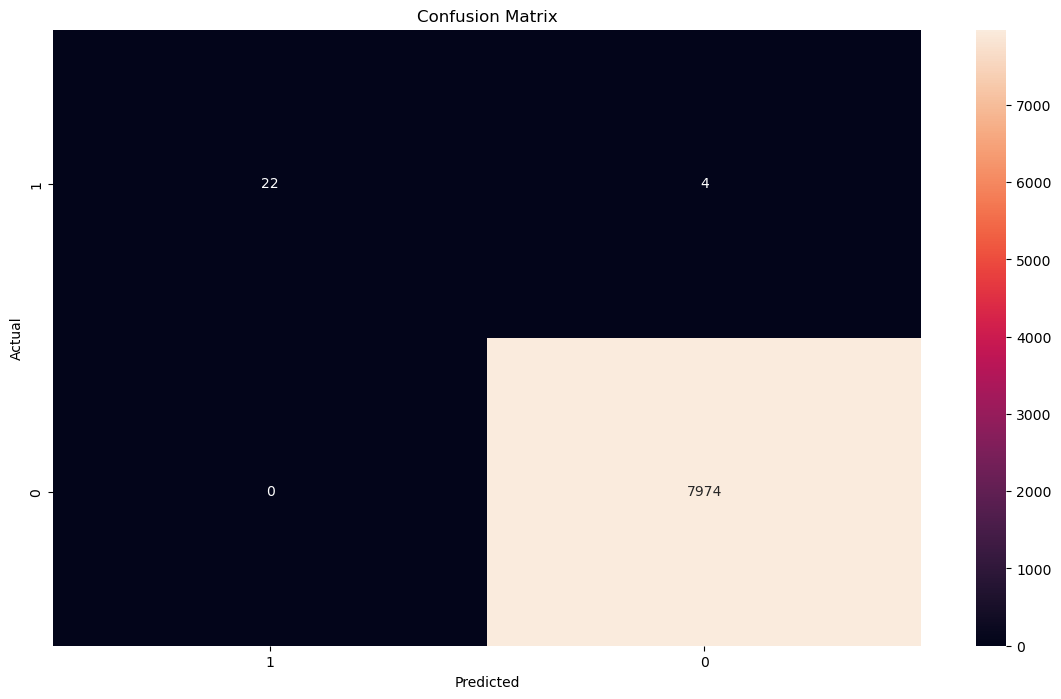

In [90]:
conf_matrix = confusion_matrix(true, preds)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")

As you can see, the confusion matrix shows that the model has performed very well on this data. Not only did it classify the normal points perfectly, but it even classified most of the anomaly points correctly as well.

With that, you hopefully know more about the process of deploying and querying a model. When you deploy to a cloud platform, the querying process follows a similar path where you must deploy a model on the cloud platform and query it by sending in the data in a JSON format.

<a id='RefMLF1lrskl'></a>
## References

Alla, S., & Adari, S. (2021). Beginning MLOps with MLFlow: Deploy Models in AWS SageMaker, Google Cloud, and Microsoft Azure. Apress.

[Return to Contents of credit card dataset analysis](#1MLF1)